# Medications Score and Health Metrics

This notebook considers all the markers of health. We start with a PCA, and then work towards a 3D PCA. Next we look at the statistics.

This notebooks creates images

Fig 1a, b, c.

Fig. S3
Fig. S5

In [1]:
import os
import sys
from socket import gethostname

# this is for ffmpeg
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/miniconda3/envs/bioinformatics/bin')

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")
# an output for the images
# os.makedirs('img/health/', exist_ok=True)

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


## Read the data

In [2]:
encoder_models = 'cluster_gbrfs'; datasource = 'only Bacteria taxa and subsystems'
#encoder_models = 'cluster_gbrfs_eukaryotes'; datasource = 'all taxa and subsystems'
# encoder_models = 'cluster_gbrfs_all'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['COPF', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['COPF'] = cluster_assignments['COPF'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)


In [3]:
intcols = ['IP vs OP', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank','Antibiotics_YN', 'Sum of antibiotics', 
           'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']

intcol = intcols[1]
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcols)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

# 0. Are the metadata values correlated?

First, we encode the antibiotics and IP/OP, and then we use our PCA trick to get a single number for the "Medications Score". Finally, we see if that is correlated.

In [5]:
md = metadata[intcols].dropna(subset=intcols)
# here we encode the IP vs OP and Antibiotics_YN
md['IP vs OP enc'] = md['IP vs OP'].astype('category').cat.codes
md['Antibiotics_YN_enc'] = md['Antibiotics_YN'].astype('category').cat.codes

reorder = ['IP vs OP', 'IP vs OP enc', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank','Antibiotics_YN', 'Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
md = md[reorder]

In [6]:
# PCA scaling of the data
pca = PCA(n_components=1)

# separate the columns
antibiotic_cols = ['Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
scaled = StandardScaler().fit_transform(md[antibiotic_cols])
tmp = pca.fit_transform(scaled)
md['Medications Score'] = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 100

if False:
    # we don't really need this because it is the same as the FEV1 Ratio Score
    fev_cols = ['IP vs OP enc', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank']
    scaled = StandardScaler().fit_transform(md[fev_cols])
    md['FEV1 Score'] = pca.fit_transform(scaled)


### Correlation of the Medication Score
The medications score is weakly correlated with IP/OP, FEV1, etc, but is correlated with antibiotic usage.

In [7]:
rename = {'IP vs OP enc' : 'IP or OP',
          'FEV1_RATIO_SCORE' : 'FEV1 Ratio Score',
          'FEV1_Obstruction_Rank' : 'FEV1 Obstruction Rank',
          'Antibiotics_YN_enc': 'Prescribed Antibiotics',
          'Sum of antibiotics' : 'Number of Antibiotics',
          'Sum of meds' : 'Number of Medications',
          'Sum of antifungals' : 'Number of antifungals',
          'Sum of steroid + mabs' : 'Number of steroids / m-antibodies'
         }

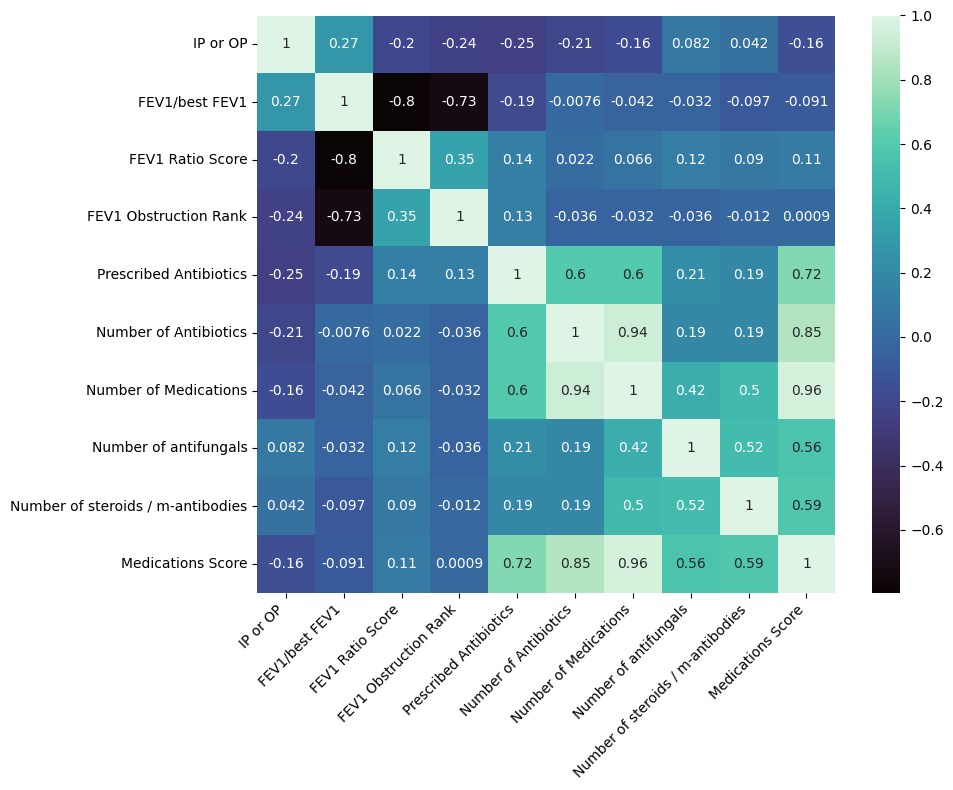

In [8]:
plt.figure(figsize=(10, 8))
md_corr = md.drop(columns=['IP vs OP', 'Antibiotics_YN']).corr()
md_corr = md_corr.rename(index=rename, columns=rename)
sns.heatmap(md_corr, annot=True, cmap='mako')
#plt.title("Medications Score Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('final_images/figS3.png', dpi=300)
plt.savefig('final_images/figS3.svg')
plt.show()

In [9]:
print(f"Supplementary Fig. 3. Pearson correlation matrix of the Medication Score and independent clinical measures. Each box is shaded by the strength and ", end="")
print(f"direction of the linear correlation (Pearson r), with the corresponding r-value shown inset (n={md.shape[0]}).")

Supplementary Fig. 3. Pearson correlation matrix of the Medication Score and independent clinical measures. Each box is shaded by the strength and direction of the linear correlation (Pearson r), with the corresponding r-value shown inset (n=125).


## Add the new Medications Score to the metadata

In [29]:
# look for missing data

print(f"NOTE: The original data has n = {pc_df.join(md).shape[0]}, but because we drop NAs from our interesting columns {intcols}, we end up with n = {pc_df.join(md).dropna(subset=intcols).shape[0]}")

NOTE: The original data has n = 127, but because we drop NAs from our interesting columns ['IP vs OP', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs', 'Medications Score'], we end up with n = 125


In [31]:
# this is the missing data
bad_rows = pc_df.join(md)[intcols].isna().any(axis=1)
pc_df.join(md).loc[bad_rows, intcols]

,IP vs OP,FEV1/best FEV1,FEV1_RATIO_SCORE,Antibiotics_YN,Sum of antibiotics,Sum of meds,Sum of antifungals,Sum of steroid + mabs,Medications Score
698917_20171207_S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895293_20180502_S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
intcols += ['Medications Score']
merged_df = pc_df.join(md).dropna(subset=intcols)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

# Cohen's d and t-test p values to test the significance of Medications Score

For the t-test (and Cohen's d) we need dichotomous data - two groups. Either Yes/No or High/Low. We recreate those groups here and then test their significance.

In [13]:
intcols = ['IP vs OP', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs', 'Medications Score']
merged_df_clean = pc_df.join(metadata[intcols[:-1]]).join(md['Medications Score']).dropna(subset=intcols)
merged_df_clean

,COPF 1,COPF 2,COPF 3,COPF 4,COPF 5,COPF 6,COPF 7,COPF 8,COPF 9,COPF 10,...,IP vs OP,FEV1/best FEV1,FEV1_RATIO_SCORE,FEV1_Obstruction_Rank,Antibiotics_YN,Sum of antibiotics,Sum of meds,Sum of antifungals,Sum of steroid + mabs,Medications Score
1068841_20180306_S,276.176615,302.702198,1546.961129,1244.654020,97582.527423,4407.930069,1853.665398,715.507023,1638.820467,2314.236268,...,OP,0.969388,1.0,1.0,No,0,0,0,0,0.000000
1447437_20171212_S,2705.663672,4690.862862,1661.627899,715.710503,-53458.096239,-392.542683,-1920.800676,-45.881704,-1404.573200,-1949.069093,...,OP,0.918919,2.0,1.0,No,0,0,0,0,0.000000
1128691_20171206_S,-603.660074,-4577.510659,-4420.313788,-4958.557622,-195353.148806,-2374.194484,-1545.660627,-1725.120119,-3424.555171,-11010.612617,...,IP,0.878788,3.0,1.0,Yes,3,3,0,0,44.015277
1128691_20171218_S,-78.550058,-3104.503785,-3654.194165,-4454.618230,-173495.186399,-1922.264320,-1179.426731,-1548.680605,-3441.985162,-8616.698464,...,OP,0.939394,2.0,1.0,Yes,1,1,0,0,23.449291
1128691_20180116_S,-1074.430518,-5052.322268,-5018.453689,-5474.994108,-215985.383039,-2426.518094,-1914.673485,-1949.175659,-3847.890163,-12551.371875,...,OP,0.818182,3.0,1.0,Yes,1,1,0,0,23.449291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892355_20180123_S,4581.030229,8797.283713,3278.711073,2077.210077,-200059.116849,-2601.979557,-4955.872845,-555.021107,-3423.564914,-3870.082608,...,OP,0.924528,2.0,1.0,Yes,2,2,0,0,33.732284
896213_20180427_S,-987.386467,-686.446202,-1049.470879,-1568.508275,-42551.788144,2037.257278,-65.971431,79.719672,-52.559735,-2532.977561,...,OP,0.925234,2.0,1.0,Yes,1,1,0,0,23.449291
913873_20180417_S,-761.521036,-446.796201,-160.302757,-852.755732,-1808.085607,3658.931376,-464.674844,-276.411538,-422.883787,1600.248043,...,IP,0.816327,3.0,1.0,No,0,0,0,0,0.000000
980574_20180403_S,-557.301890,135.000407,-522.286734,-236.762972,-2487.417301,-917.200466,-519.817611,-136.346160,-569.883346,-177.050005,...,OP,0.971014,1.0,1.0,Yes,0,0,0,0,13.166298


In [15]:
merged_df_clean['Antifungals YN'] = merged_df_clean['Sum of antifungals'].apply(lambda x: 'No' if x == 0 else 'Yes')
merged_df_clean['Meds YN'] = merged_df_clean['Sum of meds'].apply(lambda x: 'No' if x == 0 else 'Yes')
merged_df_clean['Steroids YN'] = merged_df_clean['Sum of steroid + mabs'].apply(lambda x: 'No' if x == 0 else 'Yes')
merged_df_clean['Low FEV1'] = merged_df_clean['FEV1/best FEV1'].apply(lambda x: 'No' if x > 0.9 else 'Yes')
merged_df_clean['High Medication Score'] = merged_df_clean['Medications Score'].apply(lambda x: 'No' if x < 30 else 'Yes')
merged_df_clean

,COPF 1,COPF 2,COPF 3,COPF 4,COPF 5,COPF 6,COPF 7,COPF 8,COPF 9,COPF 10,...,Sum of antibiotics,Sum of meds,Sum of antifungals,Sum of steroid + mabs,Medications Score,Antifungals YN,Meds YN,Steroids YN,Low FEV1,High Medication Score
1068841_20180306_S,276.176615,302.702198,1546.961129,1244.654020,97582.527423,4407.930069,1853.665398,715.507023,1638.820467,2314.236268,...,0,0,0,0,0.000000,No,No,No,No,No
1447437_20171212_S,2705.663672,4690.862862,1661.627899,715.710503,-53458.096239,-392.542683,-1920.800676,-45.881704,-1404.573200,-1949.069093,...,0,0,0,0,0.000000,No,No,No,No,No
1128691_20171206_S,-603.660074,-4577.510659,-4420.313788,-4958.557622,-195353.148806,-2374.194484,-1545.660627,-1725.120119,-3424.555171,-11010.612617,...,3,3,0,0,44.015277,No,Yes,No,Yes,Yes
1128691_20171218_S,-78.550058,-3104.503785,-3654.194165,-4454.618230,-173495.186399,-1922.264320,-1179.426731,-1548.680605,-3441.985162,-8616.698464,...,1,1,0,0,23.449291,No,Yes,No,No,No
1128691_20180116_S,-1074.430518,-5052.322268,-5018.453689,-5474.994108,-215985.383039,-2426.518094,-1914.673485,-1949.175659,-3847.890163,-12551.371875,...,1,1,0,0,23.449291,No,Yes,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892355_20180123_S,4581.030229,8797.283713,3278.711073,2077.210077,-200059.116849,-2601.979557,-4955.872845,-555.021107,-3423.564914,-3870.082608,...,2,2,0,0,33.732284,No,Yes,No,No,Yes
896213_20180427_S,-987.386467,-686.446202,-1049.470879,-1568.508275,-42551.788144,2037.257278,-65.971431,79.719672,-52.559735,-2532.977561,...,1,1,0,0,23.449291,No,Yes,No,No,No
913873_20180417_S,-761.521036,-446.796201,-160.302757,-852.755732,-1808.085607,3658.931376,-464.674844,-276.411538,-422.883787,1600.248043,...,0,0,0,0,0.000000,No,No,No,Yes,No
980574_20180403_S,-557.301890,135.000407,-522.286734,-236.762972,-2487.417301,-917.200466,-519.817611,-136.346160,-569.883346,-177.050005,...,0,0,0,0,13.166298,No,No,No,No,No


## Colours for the plots

In [17]:
cpalette = 'coolwarm'
meshpalette = 'BrBG_r'

### Plot the significance of each COPF. 

We find those COPFs with the smallest adjusted P-values. 

i IP or OP; ii Prescribed Antibiotics; iii Prescribed Antifungals; iv Prescribed Medications; v Prescribed Steroids; vi FEV1 Obstruction Rank; vii Low FEV1; viii High Medication Score; 


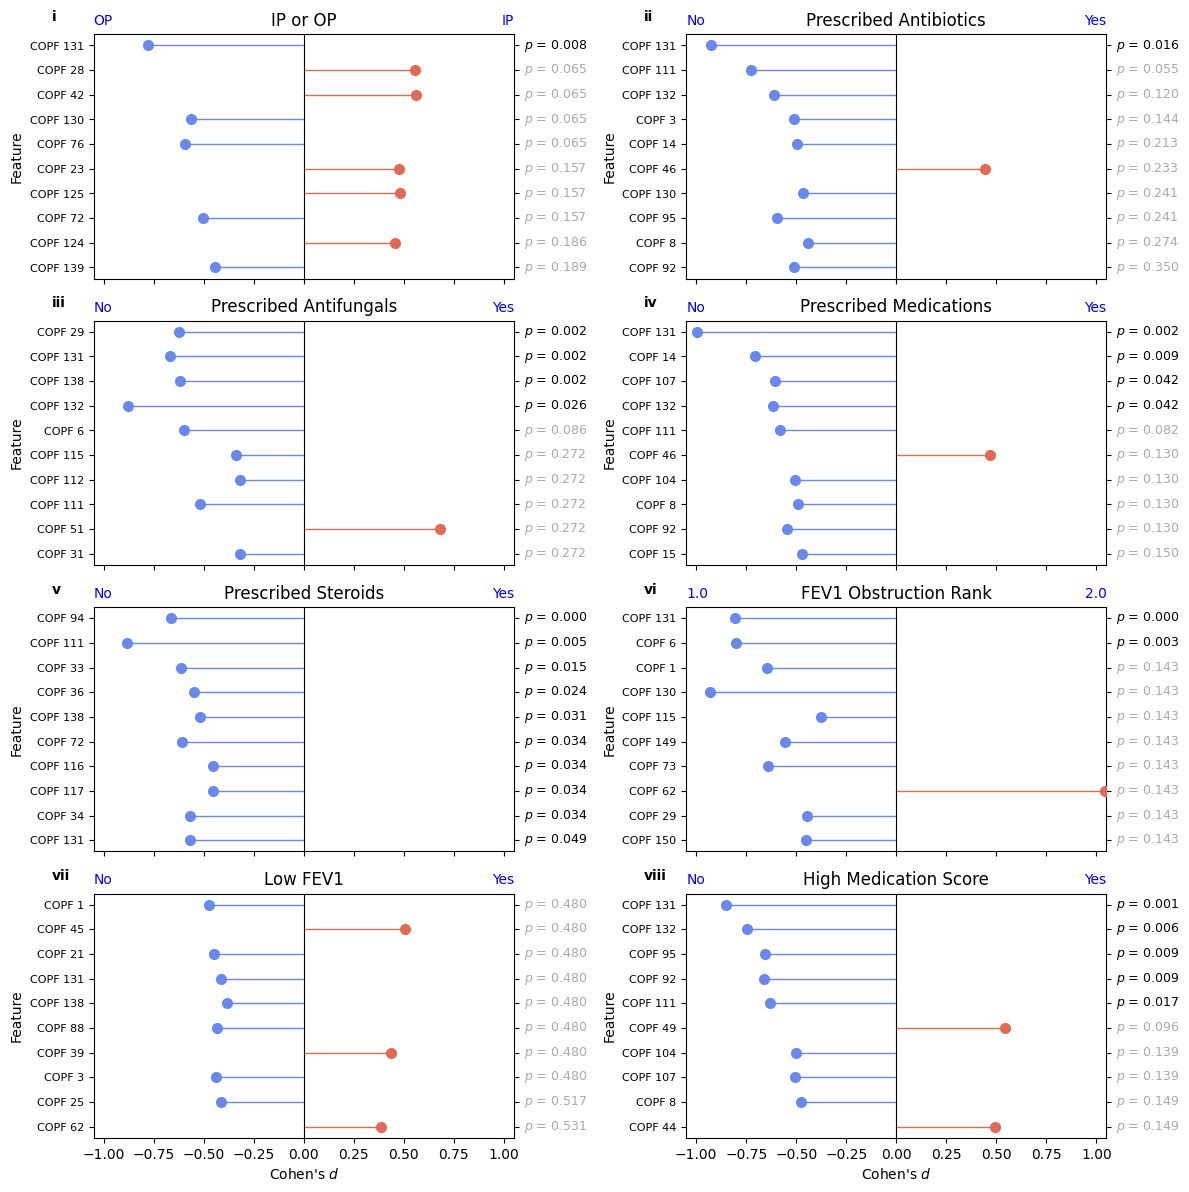

In [18]:
nrows, ncols = 4, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True)
axes[0][0].set_xlim(-1.05, 1.05)

cols_to_plot = ['IP vs OP', 'Antibiotics_YN', 'Antifungals YN', 'Meds YN', 'Steroids YN', 'FEV1_Obstruction_Rank', 'Low FEV1', 'High Medication Score'] 
col_names    = ['IP or OP', 'Prescribed Antibiotics', 'Prescribed Antifungals', 'Prescribed Medications', 'Prescribed Steroids', 'FEV1 Obstruction Rank', 'Low FEV1', 'High Medication Score']
num_ns = []

for i, intcol in enumerate(cols_to_plot):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    
    # intcol_title = replace_index.sub('', intcol).replace('_', ' ')
    intcol_title = col_names[i]
    grps = sorted(merged_df_clean[intcol].unique())
    if intcol == 'IP vs OP':
        grps = sorted(merged_df_clean[intcol].unique(), reverse=True)
    if len(grps) > 2:
        print(f"ERROR: for idx {i} and intcol {intcol} There are {len(grps)} groups {grps}. We don't know what to do!", file=sys.stderr)
       
    group0 = merged_df_clean[merged_df_clean[intcol] == grps[0]]
    group1 = merged_df_clean[merged_df_clean[intcol] == grps[1]]
    
    pvals = {}
    for col in merged_df_clean.columns[:150]:
        stat, p = ttest_ind(group0[col], group1[col], equal_var=False)
        pvals[col] = {
            'p_value' : p,
            'cohen_d' : ((group1[col].mean() - group0[col].mean()) / (np.sqrt((group1[col].var() + group0[col].var()) / 2)))
        }
                                                                     
    # Convert and adjust
    pval_df = pd.DataFrame.from_dict(pvals, orient='index')
    pval_df['adj_p'] = multipletests(pval_df['p_value'], method='fdr_bh')[1]
    pval_df = pval_df.sort_values('adj_p')

    best_diffs = pval_df['cohen_d'][:10]
    adj_p = pval_df['adj_p'].reindex(best_diffs.index)
 
    cmap = sns.color_palette(cpalette)
    colors = [cmap[0] if v < 0 else cmap[-1] for v in best_diffs.values]
    sns.stripplot(x=best_diffs.values, y=best_diffs.index, orient='h', size=8, palette=colors, ax=ax)

    # Plot sticks manually
    for i, (y, x) in enumerate(zip(best_diffs.index, best_diffs.values)):
        if x < 0:
            ax.plot([0, x], [i, i], color=cmap[0], lw=1)  # stick line from 0 to point
        else:
            ax.plot([0, x], [i, i], color=cmap[-1], lw=1)  # stick line from 0 to point
        
    ax.axvline(0, color='black', linewidth=0.8)
    
    # add the p-value to the right hand side
    for i, (yval, pval) in enumerate(zip(best_diffs.index, adj_p)):
        #ax.text(ax.get_xlim()[1] + 0.05, i, f'{yval}: $\\it{{p}}$ = {pval:.3f}', va='center', fontsize=9)
        if pval <= 0.05:
            ax.text(ax.get_xlim()[1] + 0.05, i, f'$\\it{{p}}$ = {pval:.3f}', va='center', fontsize=9, c='k')
        else:
            ax.text(ax.get_xlim()[1] + 0.05, i, f'$\\it{{p}}$ = {pval:.3f}', va='center', fontsize=9, c='darkgrey')

    
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Cohen's $\\it{{d}}$")
    ax.set_ylabel('Feature')
    ax.set_title(f'{intcol_title}')
    # add the category to the image
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1] - 0.25, grps[0], ha='left', va='bottom', fontsize=10, c='b')
    ax.text(ax.get_xlim()[1], ax.get_ylim()[1] - 0.25, grps[1], ha='right', va='bottom', fontsize=10, c='b')
    ax.yaxis.set_ticks_position('both')   # show ticks on both left and right
    ax.tick_params(axis='y', which='both', right=True)

# labels = [f"{chr(97+i)})" for i in range(nrows*ncols)] # this makes the labels a, b, c, d
labels = [cf_analysis_lib.int2roman(i+1) for i in range(nrows*ncols)] # this makes the labels roman numerals
for ax, label in zip(axes.flat, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} {ax.get_title()}", end="; ")
print()

# plt.suptitle(f"Effect size (Cohen's $\\it{{d}}$) for health data using {datasource}") 
plt.tight_layout()
plt.savefig('final_images/fig1a.png', dpi=300)
plt.savefig('final_images/fig1a.svg')
plt.show()

# Plot a PCA of the COPFs and overlay with colours to show the medications score.

### Read the cluster virulence data to generate a mesh grid

This data is generated by `virulence_matching.py` and uses several different measures to compare the cluster annotations and the virulence factor database.

In [19]:
cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score_tokenised.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence.sort_values(by='Normalised Jaccard')

,Tokens,Virulence Factors,Intersection,Union,Jaccard Distance,Normalised Jaccard,Frac cluster virulence,Enrichment Score,Normalized Enrichment Score
Cluster,,,,,,,,,
COPF 90,10,3600,0,3610,0.000000,0.000000,0.000000,-1.000000,-1.000000
COPF 78,4,3600,0,3604,0.000000,0.000000,0.000000,-1.000000,-1.000000
COPF 149,13,3600,0,3613,0.000000,0.000000,0.000000,-1.000000,-1.000000
COPF 70,8,3600,0,3608,0.000000,0.000000,0.000000,-1.000000,-1.000000
COPF 50,5,3600,0,3605,0.000000,0.000000,0.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...
COPF 145,57,3600,11,3646,0.003017,0.407519,0.192982,-0.727251,-0.571402
COPF 131,29,3600,11,3618,0.003040,0.410673,0.379310,-0.463908,-0.302005
COPF 75,34,3600,14,3620,0.003867,0.522386,0.411765,-0.418039,-0.264254


In [20]:
[x for x in merged_df.columns if not x.startswith('COPF')]

['IP vs OP',
 'IP vs OP enc',
 'FEV1/best FEV1',
 'FEV1_RATIO_SCORE',
 'FEV1_Obstruction_Rank',
 'Antibiotics_YN',
 'Antibiotics_YN_enc',
 'Sum of antibiotics',
 'Sum of meds',
 'Sum of antifungals',
 'Sum of steroid + mabs',
 'Medications Score']

/local/edwa0468/2665173/ipykernel_3420617/973016043.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


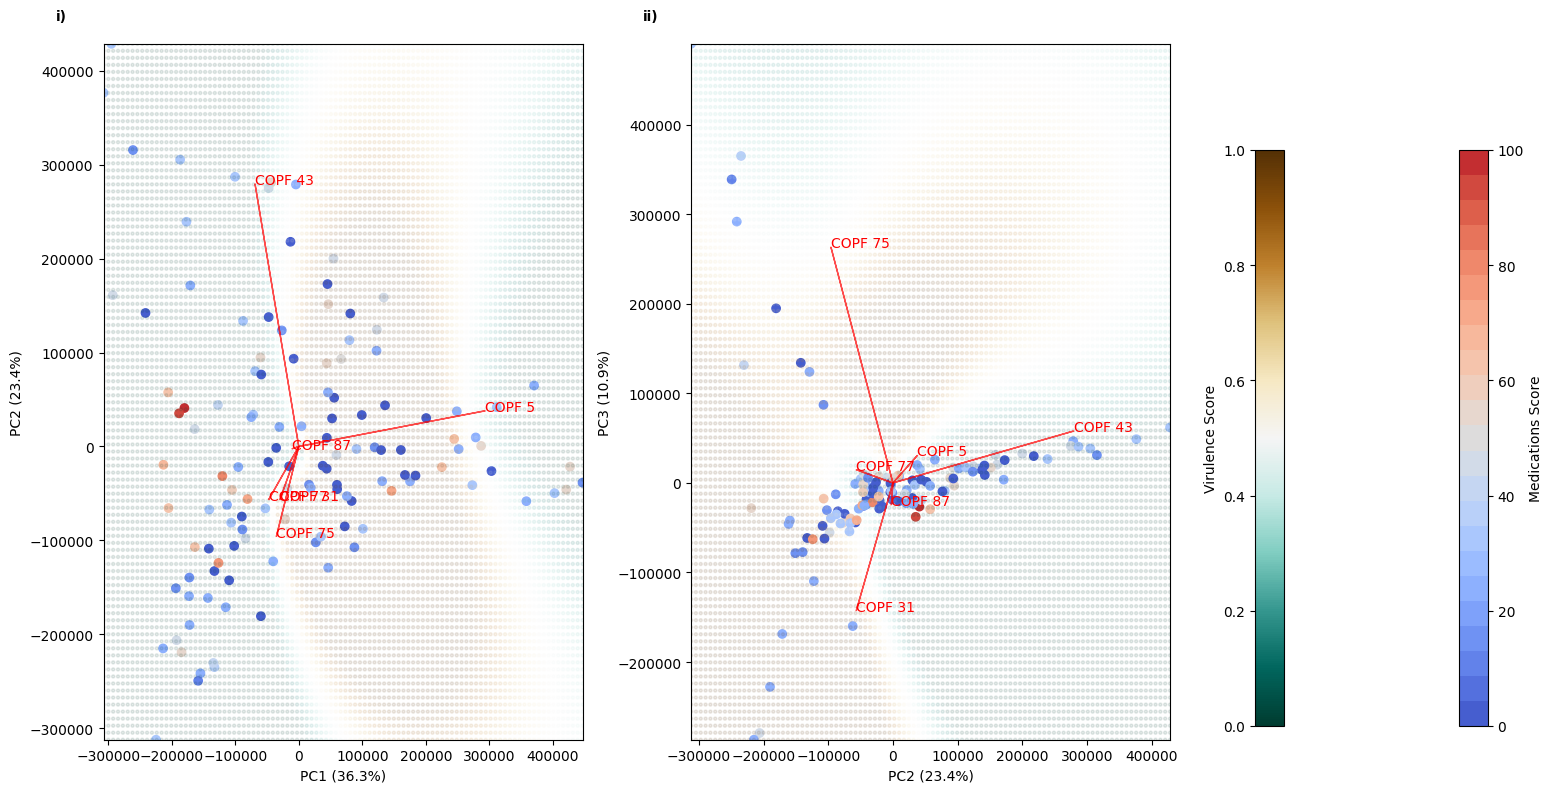

In [21]:
intcol = 'Medications Score'
#intcol = 'FEV1_Obstruction_Rank'
intcol_title = replace_index.sub('', intcol).replace('_', ' ')

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]


le = LabelEncoder()
if intcol == 'FEV1/best FEV1' or intcol == 'Medications Score':
    cols = y
else:
    cols = le.fit_transform(y)

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X)


nrows, ncols = 1, 2
comps = [(0,1), (1,2)]
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))

for i, (comp1, comp2) in enumerate(comps):
    loading_weight = round(max(pca_result[:, 0]), -5) - 90000 # this rounds to the nearest 100,000 and could be weird for another value. Probably needs generatlising
    loadings = pca.components_.T # shape: (150 variables, 4 PCs)
    x_load, y_load = loadings[:, comp1]*loading_weight, loadings[:, comp2]*loading_weight
    topN = 6
    loading_magnitude = np.sum(loadings**2, axis=1)
    top_indices = np.argsort(loading_magnitude)[-topN:]  # Top topN variables

    # Get enrichment scores for each variable
    es = 'Normalised Jaccard' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence', 'Normalised Jaccard', 'Normalised Enrichment Score',
    enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]
    
    # 3. Create grid
    grid_x, grid_y = np.mgrid[min(pca_result[:, comp1])-1:max(pca_result[:, comp1])+1:100j, min(pca_result[:, comp2])-1:max(pca_result[:, comp2])+1:100j]
    
    # 4. RBF interpolation
    points = np.column_stack((x_load, y_load))
    values = np.array(enrichment_scores)
    rbf = RBFInterpolator(points, values, kernel='thin_plate_spline')
    x_range = np.linspace(min(pca_result[:,comp1])-2, max(pca_result[:,comp1])+2, 100)
    y_range = np.linspace(min(pca_result[:,comp2])-2, max(pca_result[:,comp2])+2, 100)
    
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.column_stack((xx.ravel(), yy.ravel()))
    grid_vals = rbf(grid_points)
    grid_vals = np.clip(grid_vals, min(enrichment_scores), max(enrichment_scores))
    
    # 5. Plot PCA scatter
    scatter = axes[i].scatter(pca_result[:, comp1], pca_result[:, comp2], 
                          c=cols, cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
    
    
    # 6. Overlay mesh
    mesh = axes[i].scatter(grid_points[:, 0], grid_points[:, 1], c=grid_vals, cmap=meshpalette, alpha=0.1, s=5)
    
    #cbar = plt.colorbar(mesh)
    #cbar.set_label(es)
    

    
    # 7. Plot loadings arrows
    for ix in top_indices:
        axes[i].arrow(0, 0, loadings[ix, comp1]*loading_weight, loadings[ix, comp2]*loading_weight, color='r', alpha=0.7, head_width=0.1)
        axes[i].text(loadings[ix, comp1]*loading_weight, loadings[ix, comp2]*loading_weight, X.columns[ix], color='r', fontsize=10)
    
    axes[i].set_xlabel(f'PC{comp1+1} ({pca.explained_variance_ratio_[comp1]*100:.1f}%)')
    axes[i].set_ylabel(f'PC{comp2+1} ({pca.explained_variance_ratio_[comp2]*100:.1f}%)')
    #plt.title(f'PCA with {es} Mesh Overlay coloured {intcol_title}')
    axes[i].set_xlim(min(pca_result[:,comp1]), max(pca_result[:,comp1]))
    axes[i].set_ylim(min(pca_result[:,comp2]), max(pca_result[:,comp2]))


axes[0].text(-0.1, 1.05, "i)", transform=axes[0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
axes[1].text(-0.1, 1.05, "ii)", transform=axes[1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

cax = fig.add_axes([1.05, 0, 0.2, 0.9])  # [left, bottom, width, height]
#cax = fig.add_axes([0, -0.25, 0.9, 0.15])  # [left, bottom, width, height]
cax.axis('off')
cax.tick_params(left=False, right=False)

plt.colorbar(scatter, 
             ax=cax, 
             label=intcol_title, 
             location='right',
             shrink=0.8, 
             aspect=20)

sm = ScalarMappable(cmap=meshpalette, norm=mesh.norm)
sm.set_array([])
cb = plt.colorbar(sm,
                  ax=cax,
                  label='Virulence Score',
                  location='left',
                  shrink=0.9, 
                  aspect=20)

plt.grid(False)
plt.tight_layout()
plt.savefig('final_images/fig1b.png', dpi=300)
plt.savefig('final_images/fig1b.svg', dpi=300)
plt.show()


# --- Save scatter colorbar separately ---
fig_cb1, ax_cb1 = plt.subplots(figsize=(4, 1))
cb1 = plt.colorbar(scatter, cax=ax_cb1, orientation='horizontal', location='top')
cb1.set_label(intcol_title)
fig_cb1.tight_layout()
fig_cb1.savefig('final_images/fig1b_scatter_colorbar.png', dpi=300)
fig_cb1.savefig('final_images/fig1b_scatter_colorbar.svg', dpi=300)

# --- Save mesh colorbar separately ---
fig_cb2, ax_cb2 = plt.subplots(figsize=(4, 1))
sm = ScalarMappable(cmap=meshpalette, norm=mesh.norm)
sm.set_array([])
cb2 = plt.colorbar(sm, cax=ax_cb2, orientation='horizontal', location='bottom')
cb2.set_label('Virulence Score')
fig_cb2.tight_layout()
fig_cb2.savefig('final_images/fig1b_mesh_colorbar.png', dpi=300)
fig_cb2.savefig('final_images/fig1b_mesh_colorbar.svg', dpi=300)
plt.close(fig_cb1)
plt.close(fig_cb2)

# Fig S4 Statistical Analysis

We're using `statsmodels` for some of this, and it completely craps out if there are spaces in the column names, so we start by fixing that.

We initially tried a MANOVA but we have number of variables (150) > number of samples (125) so the stats breaks down :(

i PCoA by IP vs OP; ii PCoA by FEV1/best FEV1; iii PCoA by FEV1 RATIO SCORE; iv PCoA by Antibiotics YN; v PCoA by Sum of antibiotics; vi PCoA by Sum of meds; vii PCoA by Sum of antifungals; viii PCoA by Sum of steroid + mabs; ix PCoA by Medications Score; 


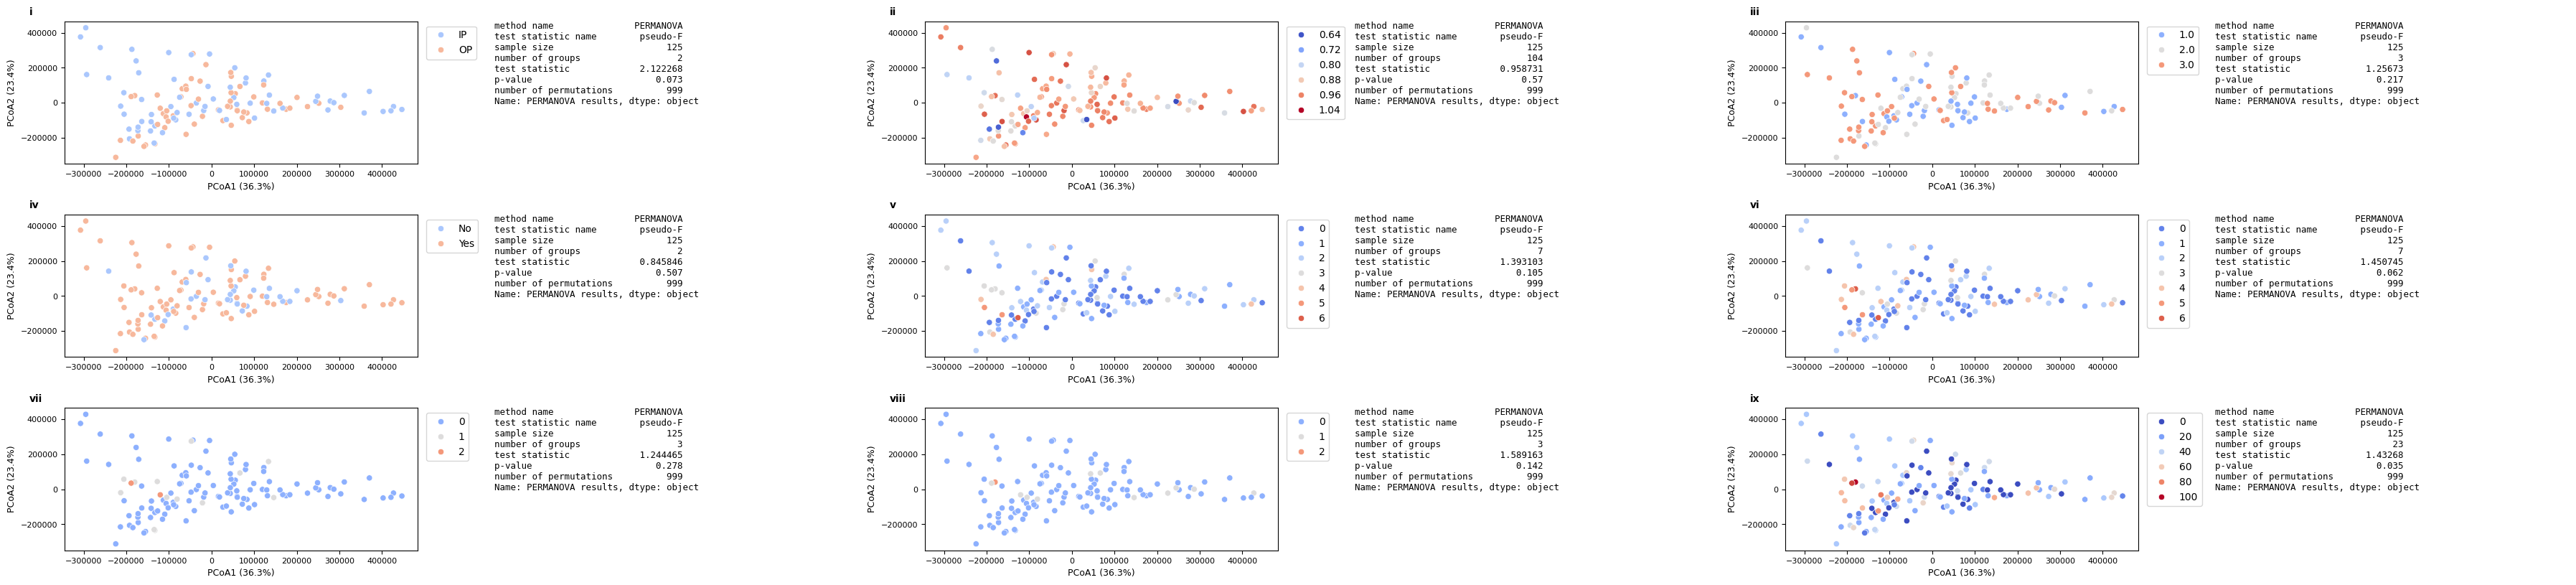

In [22]:
if len(intcols)==10 and 'FEV1_Obstruction_Rank' in intcols:
    intcols.remove('FEV1_Obstruction_Rank')

# prepare the distance matrix
X = merged_df_clean.iloc[:, :150].values
dist_matrix = pairwise_distances(X, metric='euclidean')
dist_rounded = np.round(dist_matrix, decimals=8)
dist_matrix = (dist_rounded + dist_rounded.T) / 2
dm = DistanceMatrix(dist_matrix, ids=merged_df_clean.index.astype(str))

fig = plt.figure(figsize=(36, 24))

gs = GridSpec(len(intcols), 6, figure=fig)

first_ax = []
offset_col = 0
axes = []
ncols = 3
for i, intcol in enumerate(intcols):
    row, col = divmod(i, ncols)
    col *=2 

    if len(first_ax) <= row:
        first_ax.append(None)
    
    intcol = intcols[i]
    intcol_title = intcol.replace('_', ' ')
   
    if first_ax[row]:
        ax_pcoa = fig.add_subplot(gs[row, col], sharex=first_ax[row])
    else:
        ax_pcoa = fig.add_subplot(gs[row, col])
        first_ax[row] = ax_pcoa
    axes.append(ax_pcoa)
    # plot the PCoA
    pcoa_results = pcoa(dm)
    coords = pcoa_results.samples
    joint = merged_df_clean[[intcol]].join(coords[['PC1', 'PC2']])

    if intcol == 'IP_vs_OP':
        mypal = f"{cpalette}_r"
    else:
        mypal = cpalette
    g = sns.scatterplot(data=joint, x='PC1', y='PC2', hue=intcol, palette=mypal, ax=ax_pcoa)
    g.set_xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}%)')
    g.set_ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}%)')

    g.tick_params(axis='x', labelsize=8)
    g.tick_params(axis='y', labelsize=8)

    g.set_xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}%)', fontsize=9)
    g.set_ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}%)', fontsize=9)
    g.set_title(f'PCoA by {intcol_title}')
    #g.set_title("")
    if intcol == 'FEV1/best_FEV1' or intcol == 'Medications_Score':
        g.legend().remove()
    else:
        g.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

    # add the text on the right
    result = permanova(dm, merged_df_clean[intcol], permutations=999)
    ax_text = fig.add_subplot(gs[row, col+1])
    n = ax_text.axis('off')
    n = ax_text.text(0, 1, result, ha='left', va='top', fontsize=9, family='monospace')


# labels = [f"{chr(97+i)})" for i in range(len(axes))]
labels = [cf_analysis_lib.int2roman(i+1) for i in range(len(axes))] # this makes the labels roman numerals
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} {ax.get_title()}", end="; ")
    ax.set_title("")
print()

plt.tight_layout()
plt.savefig('final_images/figs4.png', dpi=300)
plt.savefig('final_images/figs4.svg')
plt.show()



# Fig. 1c and Fig S5

This figure shows the normalised read abundance for the COPFs associated with health. We end up with a figure with 7 panels, but I plot a) separately - COPF131 since that is the most important above, and it allows me to discuss it in the paper. Then I plot b-g separately.

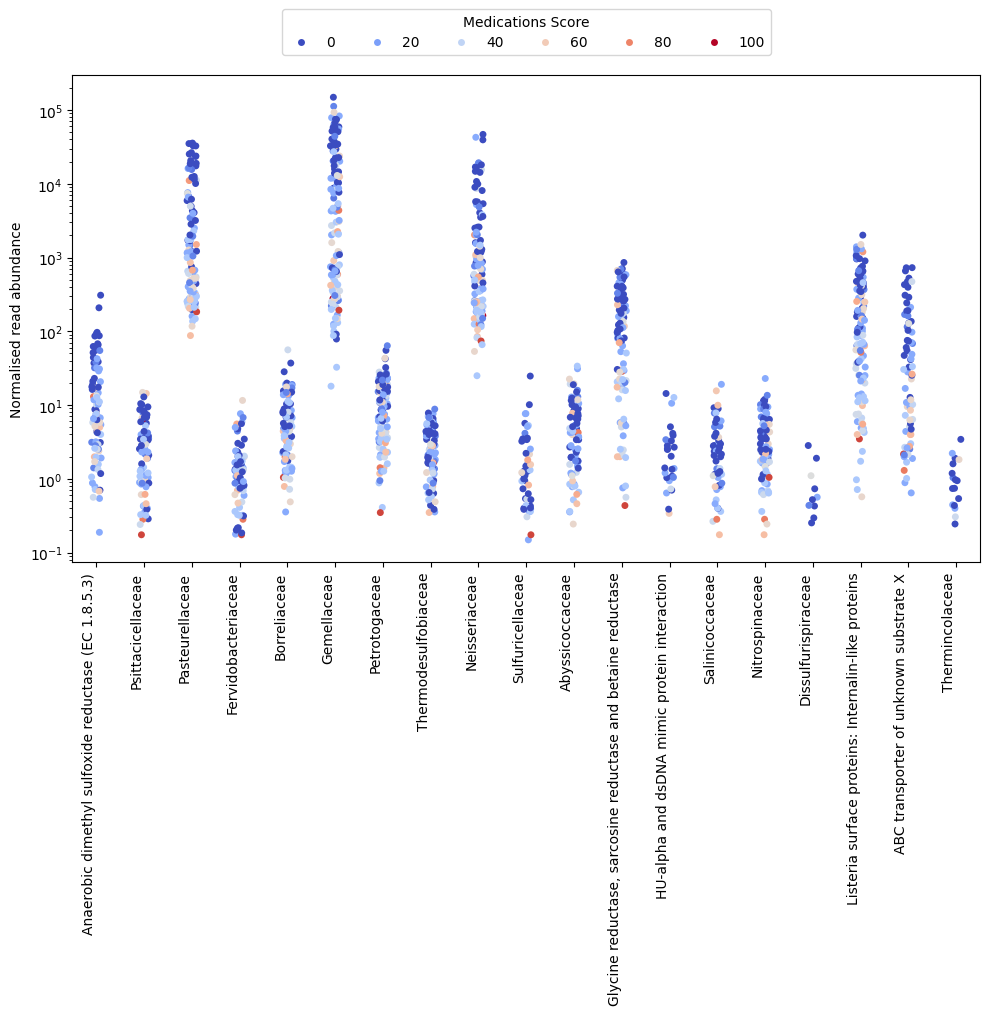

In [32]:
intcluster = 131
plt.figure(figsize=(10, 11))
tdf = df[list(cluster_assignments[cluster_assignments['COPF'] == intcluster].Feature)].join(merged_df_clean[['Medications Score']], how='inner')
long_df = tdf.melt(id_vars=tdf.columns[19],  # column 20 as hue
                   value_vars=tdf.columns[:19],
                   var_name='Variable', value_name='Value')

# Plot
ax = sns.stripplot(data=long_df, x='Variable', y='Value', hue=tdf.columns[19], jitter=True, palette=cpalette)
ax.set_yscale('log')
ax.set_ylabel('Normalised read abundance')
ax.set_xlabel(" ")
plt.xticks(rotation=90, ha='right')

plt.legend(title=tdf.columns[19].replace('_', ' '), loc='upper center', bbox_to_anchor=(.5, 1.15), ncol=6)
#plt.legend(title=tdf.columns[19].replace('_', ' '), loc='upper left', bbox_to_anchor=(1.05, 1))
#ax.text(-0.1, 1.1, "i)", transform=ax.transAxes,
#            fontsize=10, fontweight='bold', va='top', ha='left')
plt.tight_layout()
plt.savefig('final_images/fig1c.png', dpi=300)
plt.savefig('final_images/fig1c.svg')
plt.show()

i) COPF 14 (n = 125); ii) COPF 6 (n = 125); iii) COPF 107 (n = 125); iv) COPF 29 (n = 125); v) COPF 138 (n = 125); vi) COPF 132 (n = 125); 


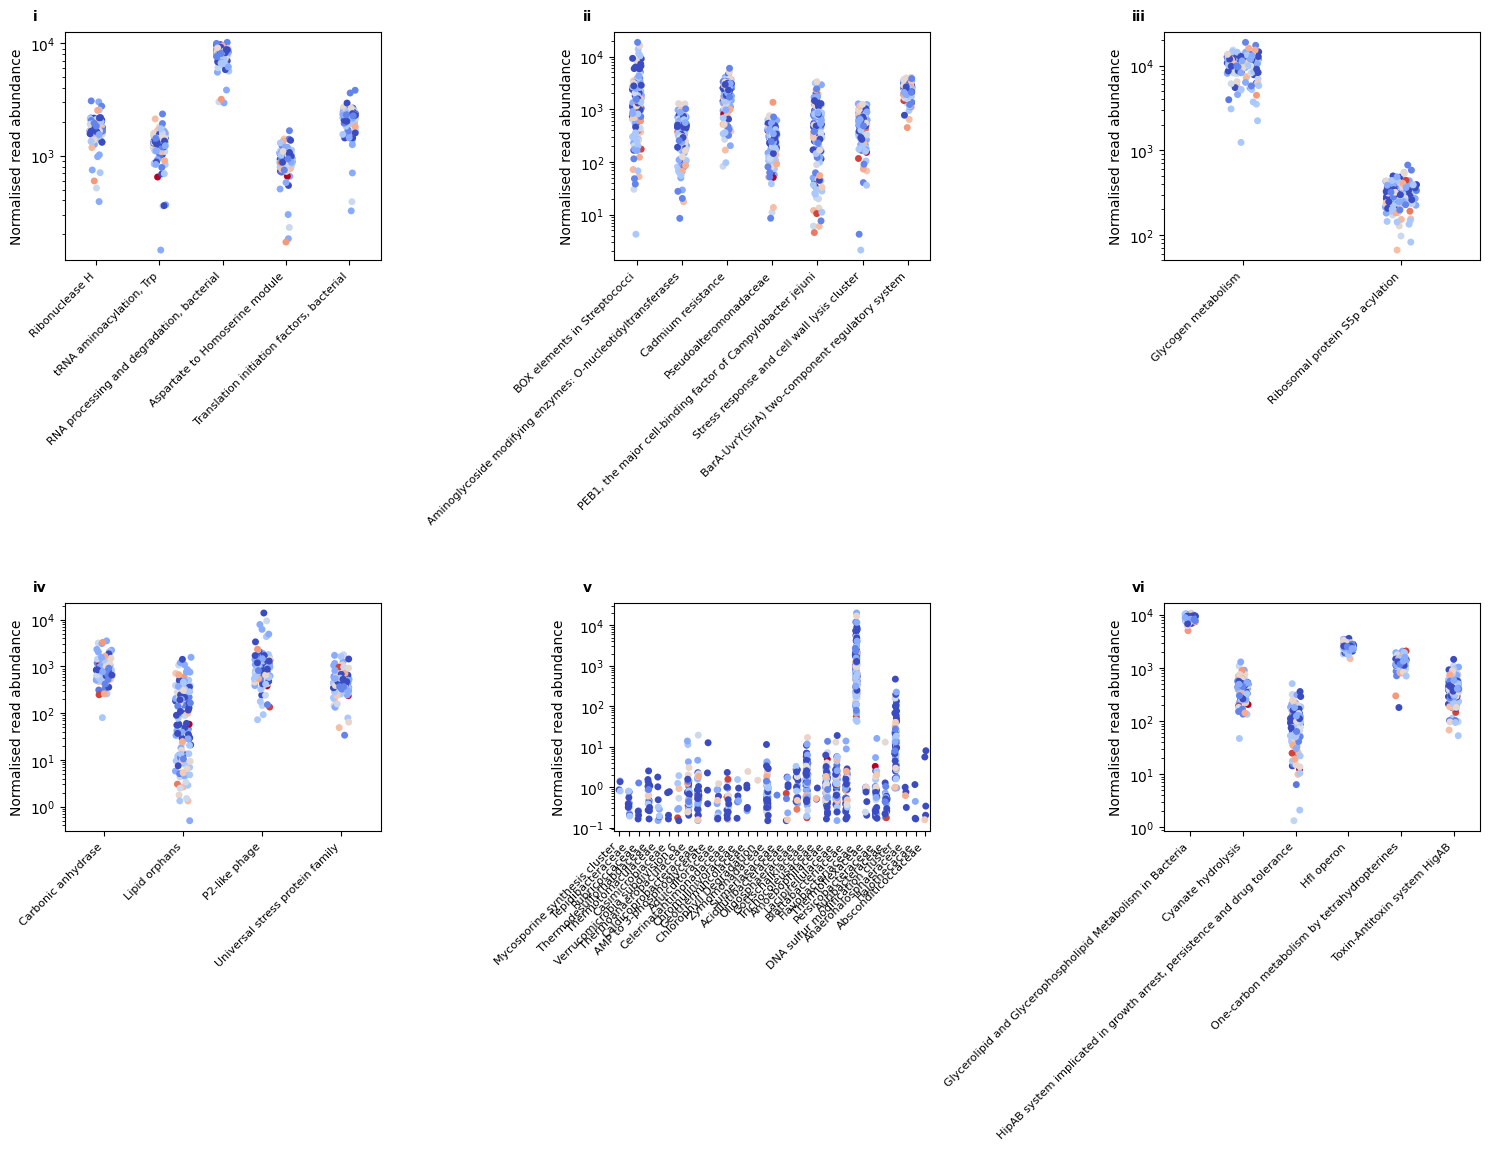

In [37]:
nrows, ncols = 2, 3
# interesting_clusters = [131, 14, 6, 29, 138, 132]
interesting_clusters = [14, 6, 107, 29, 138, 132]
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))

num_ns = []
for i, intcluster in enumerate(interesting_clusters):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    
    tdf = df[list(cluster_assignments[cluster_assignments['COPF'] == intcluster].Feature)].join(merged_df_clean[['Medications Score']], how='inner')
    num_ns.append(tdf.shape[0])
    long_df = tdf.melt(id_vars=tdf.columns[-1],  # column 20 as hue
                       value_vars=tdf.columns[:-1],
                       var_name='Variable', value_name='Value')
    
    # Plot
    sns.stripplot(data=long_df, x='Variable', y='Value', hue=tdf.columns[-1], jitter=True, palette=cpalette, ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel('Normalised read abundance')
    ax.set_xlabel(" ")
    ax.legend().remove()
    #plt.xticks(rotation=45, ha='right')
    #ax.set_ticks(ax.get_ticks())
    #labels = [label.get_text()[:30] for label in ax.get_xticklabels()]
    #ax.set_xticklabels(labels, rotation=45, fontsize=8, ha='right')
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    # Explicitly fix the tick positions first
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, fontsize=8, ha='right')


#labels = [f"{chr(98+i)})" for i in range(nrows*ncols)]
labels = [cf_analysis_lib.int2roman(x+1) for x in range(nrows*ncols)]
for i, (ax, label) in enumerate(zip(axes.flat, labels)):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label}) COPF {interesting_clusters[i]} (n = {num_ns[i]})", end="; ")
print()

#plt.legend(title=tdf.columns[-1].replace('_', ' ').replace('(Medications)', ''), loc='upper left', bbox_to_anchor=(1.05, 1))
#axes[0, 1].legend(title=tdf.columns[-1].replace('_', ' ').replace('(Medications)', ''), loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('final_images/figs5.png', dpi=300)
plt.savefig('final_images/figs5.svg')
plt.show()